# Graph Neural Networks (GNNs)

Graph Neural Networks (GNNs) are a class of neural networks specifically designed to process data that is structured as graphs. They are particularly effective in capturing the relationships and dependencies between entities represented as nodes and edges in a graph.

## Key Concepts

- **Graph Representation**: In a GNN, data is represented as a graph $G = (V, E)$, where $V$ is the set of nodes (vertices) and $E$ is the set of edges connecting pairs of nodes. Each node and edge can have associated features that provide additional information.

- **Message Passing**: GNNs operate through a process known as message passing, where nodes iteratively update their representations by aggregating information from their neighbors. This allows the network to capture local and global structural information within the graph.

- **Permutation Invariance**: A fundamental property of GNNs is permutation invariance, meaning that the output of the network does not depend on the order of the nodes in the input graph. This ensures that the model's predictions are consistent regardless of node ordering.

In [1]:
%%capture
# Example usage
import sys

# Añade el directorio principal al path de búsqueda para importar módulos desde esa ubicación
sys.path.insert(0, "..")

import pandas as pd
from sklearn.datasets import load_iris
import numpy as np
import tensorflow as tf

from likelihood.graph.nn import Data, VanillaGNN
from likelihood.tools import graph_metrics

## Vanilla Graph Neural Networks (Vanilla GNNs)

Vanilla GNNs, introduced by Scarselli et al. in 2009, are the foundational models of graph-based neural networks. They are simple yet powerful models designed for learning on graph-structured data.

### Key Features:
- **Message Passing Scheme**: In Vanilla GNNs, each node updates its representation by receiving messages (features) from its neighbors in the graph. This message passing occurs over several iterations to capture broader graph structures.
- **Neighborhood Aggregation**: Each node aggregates features from its immediate neighbors (and potentially higher-order neighbors in further layers), updating its own representation.

### Limitations of Vanilla GNNs:
- **Expressive Power**: Vanilla GNNs are limited in their expressive power and can struggle with distinguishing non-isomorphic graphs. This is because they rely on a relatively simple message-passing scheme.
- **Over-Smoothing**: As the depth of the GNN increases, node representations may converge, leading to the over-smoothing problem where nodes’ embeddings become indistinguishable.
  
Researchers have proposed advanced variants of GNNs to address these issues, including GCNs, GATs, and more.

## Applications

GNNs have been successfully applied in various domains, including:

- **Social Networks**: Modeling relationships and interactions between individuals to predict behaviors or identify communities.

- **Recommendation Systems**: Leveraging user-item interaction graphs to provide personalized recommendations.

- **Drug Discovery**: Predicting molecular properties by representing molecules as graphs, where nodes are atoms and edges are chemical bonds. ([en.wikipedia.org](https://en.wikipedia.org/wiki/Graph_neural_network?))

- **Computer Vision**: Analyzing images by treating pixels or superpixels as nodes in a graph, capturing spatial relationships.

## Advantages

- **Expressiveness**: GNNs can model complex dependencies and structures inherent in graph data, capturing both local and global patterns.

- **Scalability**: With advancements in architecture and training techniques, GNNs can be scaled to handle large graphs commonly encountered in real-world applications.

## Challenges

- **Over-Smoothing**: As the number of message-passing layers increases, node representations can become indistinguishable, leading to performance degradation. Techniques like residual connections and attention mechanisms are employed to mitigate this issue.

- **Scalability**: Handling large-scale graphs with millions of nodes and edges poses computational challenges. Research is ongoing to develop more efficient algorithms and architectures.

## Further Reading

- [A Gentle Introduction to Graph Neural Networks](https://distill.pub/2021/gnn-intro): An accessible introduction to the concepts and mechanisms behind GNNs.

- [A Comprehensive Survey on Graph Neural Networks](https://arxiv.org/abs/1901.00596): An in-depth survey covering various GNN architectures, applications, and future directions.

- [Graph Neural Networks: Methods, Applications, and Opportunities](https://arxiv.org/abs/2108.10733): A comprehensive overview of GNN methods, their applications, and the opportunities they present across different domains.

In [2]:
# Load the dataset
iris = load_iris()

# Convert to a DataFrame for easy exploration
iris_df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
iris_df["species"] = iris.target

# Display the first few rows of the dataset
iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [3]:
iris_df = iris_df.sample(frac=1, replace=False).reset_index(drop=True)

data = Data(iris_df, "species")

model = VanillaGNN(
    dim_in=data.x.shape[1], dim_h=8, dim_out=len(iris_df["species"].unique()), rank=4
)
print("Before training F1:", model.test(data))
model.fit(data, epochs=400, batch_size=32, test_size=0.5)
model.save("./graph_model", save_format="tf")
print("After training F1:", model.test(data))
best_model = tf.keras.models.load_model("./graph_model")

Epoch 395 | Train Loss: 0.5842 | Train F1: 0.9718 | Val Loss: 1.2005 | Val F1: 0.2433


d:\Documentos\GitHub\likelihood\examples\..\likelihood\graph\nn.py:283: UserWarning: It is normal for validation metrics to underperform during training. Use the test method to validate after training.
  warnings.warn(


After training F1: 0.98
Input shape: (150, 4)
Dense weights shape: 4x8
LoRA weights shape: A(4, 4), B(4, 8)
Input shape: (150, 8)
Dense weights shape: 8x8
LoRA weights shape: A(8, 4), B(4, 8)


In [4]:
print("After loading F1:", best_model.test(data))
df_results = pd.DataFrame()

# Suppose we have a new dataset without the target variable
iris_df = iris_df.drop(columns=["species"])
data_new = Data(iris_df)
print("Predictions:", best_model.predict(data_new))
df_results["predicted"] = list(model.predict(data))
df_results["actual"] = list(data.y)

After loading F1: 0.98
Predictions: [2 2 0 0 0 2 2 0 2 0 1 0 0 1 0 2 2 0 1 1 1 2 2 1 0 1 1 0 0 1 2 2 2 0 2 0 2
 0 2 0 2 2 2 1 1 0 0 0 0 2 2 0 0 0 1 2 2 2 1 0 0 1 2 1 2 2 2 1 1 2 0 2 0 2
 2 0 2 0 1 1 0 0 1 2 2 0 0 1 2 1 1 1 1 0 2 1 0 1 2 2 2 1 1 1 1 0 0 1 1 2 2
 2 2 2 2 2 0 0 2 2 1 2 1 1 1 0 0 2 2 0 1 0 2 1 1 0 0 0 2 1 0 2 1 2 0 0 2 1
 2 0]


In [5]:
data = Data(iris_df, sparse=False)
gnn_df = graph_metrics(data.adjacency)
gnn_df.head()

,Degree,Degree Centrality,Clustering Coefficient,Eigenvector Centrality,Betweenness Centrality,Closeness Centrality,Assortativity
0,7,0.046980,0.3,0.000713,0.002048,0.107399,0.4436
1,7,0.046980,0.6,0.001471,0.005294,0.113489,0.4436
2,3,0.020134,0.0,0.000000,0.000000,0.006711,0.4436
3,2,0.013423,0.0,0.000000,0.000000,0.000000,0.4436
4,11,0.073826,0.5,0.000157,0.006111,0.119645,0.4436


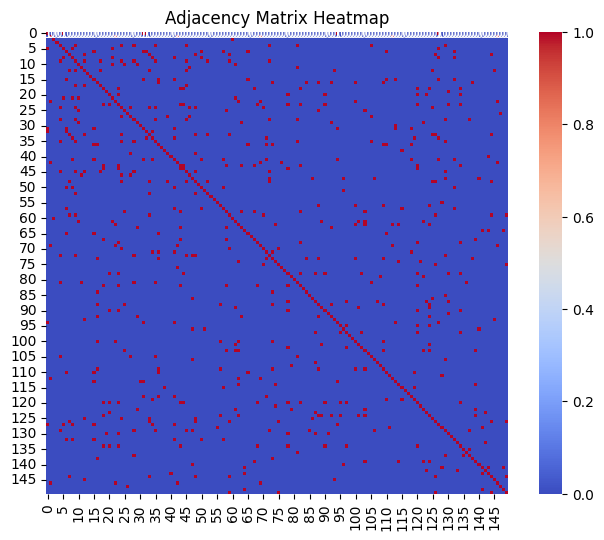

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx


def plot_adjacency_heatmap(adj_matrix, figsize=(8, 6)):
    """Plots a heatmap for the given adjacency matrix."""
    adj_matrix = np.array(adj_matrix)
    plt.figure(figsize=figsize)
    sns.heatmap(adj_matrix, annot=True, cmap="coolwarm", cbar=True, square=True)
    plt.title("Adjacency Matrix Heatmap")
    plt.show()


def plot_graph_from_adjacency(adj_matrix, figsize=(8, 6)):
    """Plots a graph based on the given adjacency matrix."""
    adj_matrix = np.array(adj_matrix)
    np.fill_diagonal(adj_matrix, 0.0)
    G = nx.from_numpy_array(adj_matrix, create_using=nx.DiGraph)
    plt.figure(figsize=figsize)
    pos = nx.kamada_kawai_layout(G, weight=None)
    degrees = [val for _, val in G.degree()]
    node_color = degrees
    cmap = plt.cm.viridis
    nx.draw(
        G,
        pos,
        with_labels=True,
        node_size=500,
        node_color=node_color,
        cmap=cmap,
        font_size=8,
        font_weight="bold",
        edge_color="gray",
        width=1,
        alpha=0.8,
        edgecolors="black",
        font_color="black",
        arrows=True,
    )

    plt.title("Graph Representation of Adjacency Matrix", fontsize=16)
    plt.axis("off")
    plt.show()


plot_adjacency_heatmap(data.adjacency)

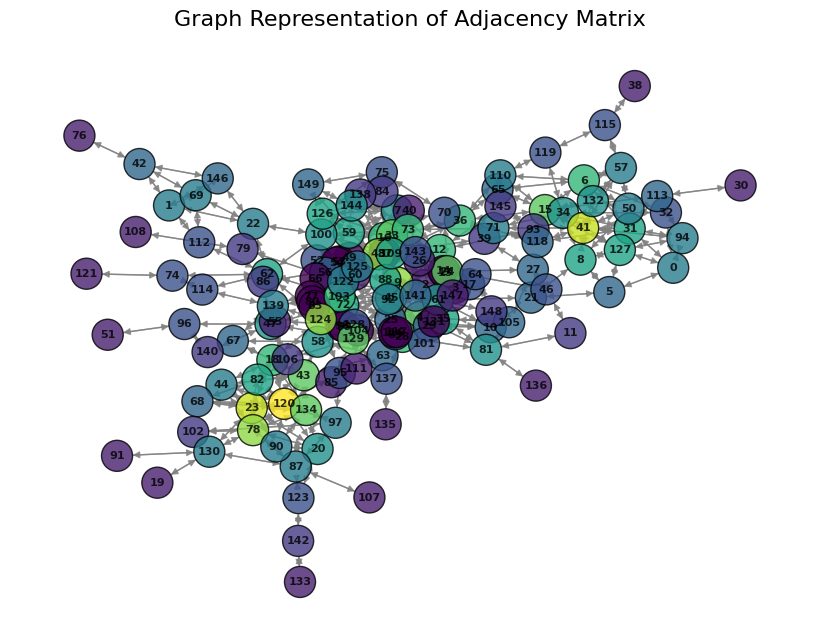

In [7]:
plot_graph_from_adjacency(data.adjacency)